<a href="https://colab.research.google.com/github/hazemshaban/8_puzzle_AI_project/blob/master/mobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/facialDataset/

/content/drive/MyDrive/facialDataset


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

import warnings

# to create a tensor on the gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings('ignore')

In [4]:
import os
import cv2
import math
import numpy as np
import pandas as pd

#import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

In [12]:
filename = "/content/drive/MyDrive/facialDataset/icml_face_data.csv"

emotions = ['Angry',  'Disgust',  'Fear',  'Happy',  'Sad',  'Surprise', 'Neutral']

In [13]:
icml_faces = pd.read_csv(filename)
icml_faces

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [14]:
def plot_images(df, emotion_class):

    emo_df = df[df.emotion==emotion_class]

    row = emo_df.sample(1)

    img = np.fromstring(row[' pixels'].iloc[0], dtype=int, sep=' ')

    img = np.reshape(img, (48, 48))

    image = np.zeros((48,48,3))

    image[:,:,0] = img

    image[:,:,1] = img

    image[:,:,2] = img

    image = np.array(image.astype(np.uint8))

    return image



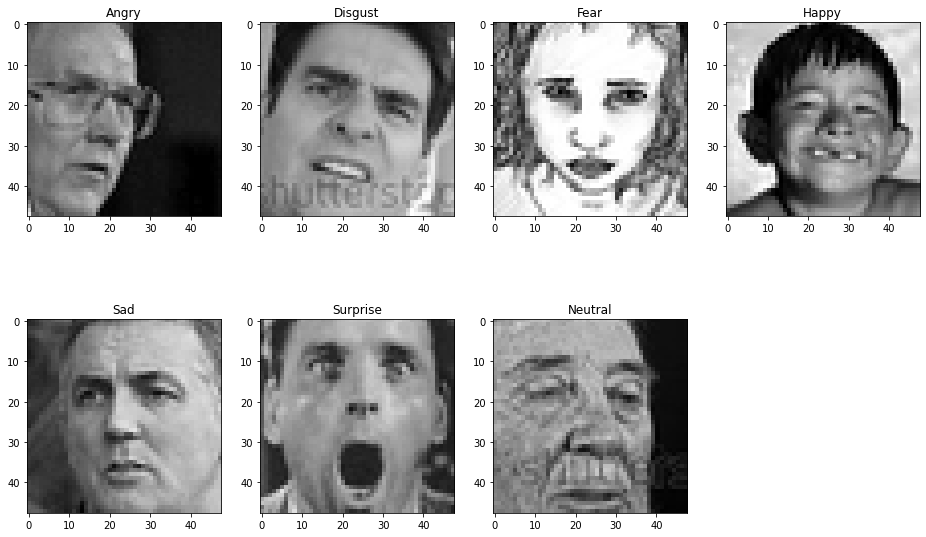

In [15]:

plt.figure(0, figsize=(16,10))

for i in range(7):

    plt.subplot(2,4,i+1)

    image = plot_images(icml_faces,i)

    plt.imshow(image)

    plt.title( emotions[i])

In [16]:
icml_faces['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [17]:
def prepare_data(data):
    """ Prepare data for modeling
        input: data frame with labels and pixel data
        output: image and label array """

    image_array = np.zeros(shape=(len(data), 1, 48, 48))
    image_label = np.array(list(map(int, data['emotion']))).reshape(len(data), 1)

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (1, 48 , 48))
        image_array[i] = image

    return image_array, image_label

In [18]:
x_train, y_train = prepare_data(icml_faces[icml_faces[' Usage'] == 'Training'])
x_val, y_val = prepare_data(icml_faces[icml_faces[' Usage'] == 'PrivateTest'])
x_test, y_test = prepare_data(icml_faces[icml_faces[' Usage'] == 'PublicTest'])

In [19]:
x_train=np.reshape(x_train,(x_train.shape[0],48,48,1))
x_val=np.reshape(x_val,(x_val.shape[0],48,48,1))
x_test=np.reshape(x_test,(x_test.shape[0],48,48,1))

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((28709, 48, 48, 1),
 (28709, 1),
 (3589, 48, 48, 1),
 (3589, 1),
 (3589, 48, 48, 1),
 (3589, 1))

In [20]:
le = OneHotEncoder()
y_train = le.fit_transform(y_train).toarray()
y_val = le.fit_transform(y_val).toarray()
y_test = le.fit_transform(y_test).toarray()
y_train.shape



(28709, 7)

In [21]:

new_x_train = tf.image.grayscale_to_rgb(tf.convert_to_tensor(x_train,dtype=tf.float64))
new_x_train=new_x_train.numpy()

new_x_val = tf.image.grayscale_to_rgb(tf.convert_to_tensor(x_val,dtype=tf.float64))
new_x_val=new_x_val.numpy()
new_x_test = tf.image.grayscale_to_rgb(tf.convert_to_tensor(x_test,dtype=tf.float64))
new_x_test=new_x_test.numpy()

(28709, 48, 48, 3)


In [7]:
mobile_net = MobileNet(
    input_shape = (48, 48, 3),
    include_top = False,
    weights = "imagenet",
    classes = 7
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(7, activation="softmax", name="out_layer")(global_pool)

model = Model(inputs=mobile_net.input, outputs=out)

17235968/17225924 [==============================] - 0s 0us/step


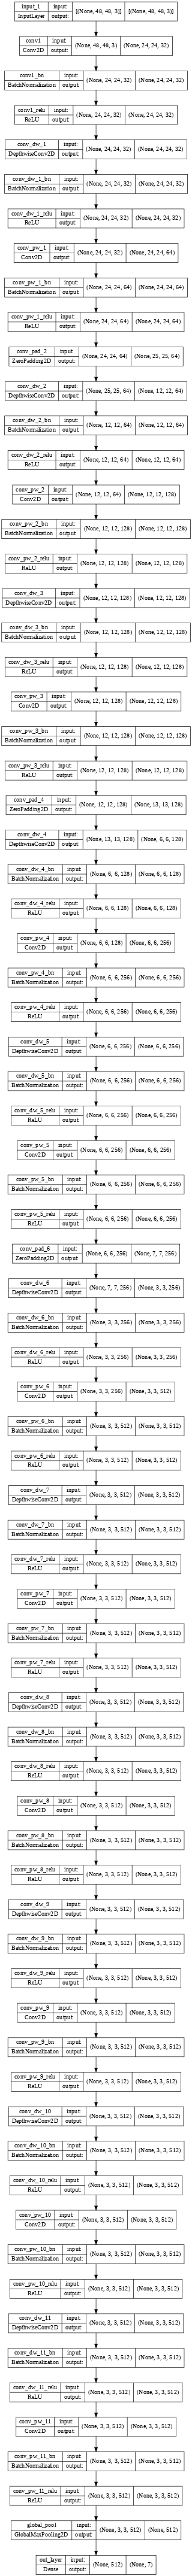

In [8]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='mobilenet.png')

In [9]:
for layer in model.layers[:15]:
    layer.trainable = False

In [22]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(new_x_train)

In [26]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [27]:
batch_size = 128
epochs = 200

optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims[1],
        metrics=['accuracy']
)

history = model.fit_generator(
    train_datagen.flow(new_x_train, y_train, batch_size=batch_size),
    validation_data=(new_x_val, y_val),
    steps_per_epoch=len(new_x_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    
)

Epoch 1/200
224/224 [==============================] - 26s 105ms/step - loss: 1.9498 - accuracy: 0.2873 - val_loss: 1.9127 - val_accuracy: 0.3639 - lr: 0.0100
Epoch 2/200
224/224 [==============================] - 22s 100ms/step - loss: 1.6050 - accuracy: 0.3794 - val_loss: 1.9945 - val_accuracy: 0.3185 - lr: 0.0100
Epoch 3/200
224/224 [==============================] - 22s 100ms/step - loss: 1.5331 - accuracy: 0.4100 - val_loss: 1.8216 - val_accuracy: 0.3229 - lr: 0.0100
Epoch 4/200
224/224 [==============================] - 22s 99ms/step - loss: 1.4759 - accuracy: 0.4385 - val_loss: 1.8665 - val_accuracy: 0.3396 - lr: 0.0100
Epoch 5/200
224/224 [==============================] - 22s 99ms/step - loss: 1.4352 - accuracy: 0.4492 - val_loss: 1.5833 - val_accuracy: 0.3856 - lr: 0.0100
Epoch 6/200
224/224 [==============================] - 24s 105ms/step - loss: 1.4012 - accuracy: 0.4633 - val_loss: 1.7919 - val_accuracy: 0.3500 - lr: 0.0100
Epoch 7/200
224/224 [===========================

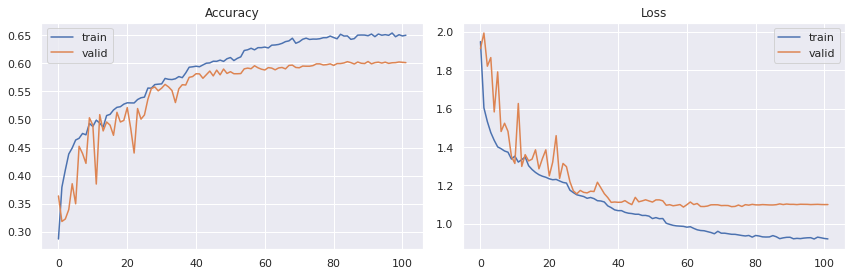

In [29]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_mobilenet.png')
pyplot.show()


In [30]:
yhat_test = np.argmax(model.predict(new_x_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)


test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

test accuracy: 57.8991 %


              precision    recall  f1-score   support

           0       0.45      0.48      0.47       467
           1       0.51      0.32      0.40        56
           2       0.45      0.35      0.40       496
           3       0.80      0.80      0.80       895
           4       0.50      0.44      0.47       653
           5       0.68      0.73      0.71       415
           6       0.47      0.59      0.52       607

    accuracy                           0.58      3589
   macro avg       0.55      0.53      0.54      3589
weighted avg       0.58      0.58      0.58      3589

